In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.image import (
    ImageDataGenerator, 
    array_to_img, 
    img_to_array, 
    load_img
)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

import os
import random
import shutil

2025-04-03 18:18:49.307015: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Working with Images

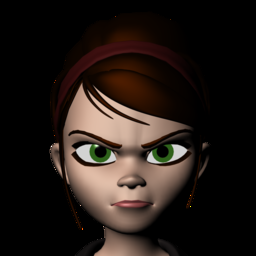

In [25]:
path_to_image = os.path.join(os.getcwd(), "data", "mery", "mery_anger", "mery_anger_100.png")

image = load_img(path_to_image)

image

In [3]:
type(image)

PIL.Image.Image

In [4]:
# Converting from PIL image types to numpy arrays is easy. Explore some properties:
img_array = img_to_array(image)
print(img_array.shape)
print(img_array.max())
print(img_array.min())

(256, 256, 3)
255.0
0.0


In [5]:
# Conversely, numpy arrays can be easilz turned into PIL images
array_to_img(img_array).size

(256, 256)

### Understanding `ImageDataGenerator` for Data Augmentation

When training deep learning models, especially in computer vision tasks, having a large dataset is crucial for improving model generalization and performance. However, collecting a large dataset can be challenging. This is where **data augmentation** helps.

#### What is `ImageDataGenerator`?
The `ImageDataGenerator` class in Keras provides a way to augment image data by applying random transformations to images in each batch during training. This helps improve model robustness and prevents overfitting.

#### Code Breakdown:

Each parameter in `ImageDataGenerator` applies a specific transformation:

- `rotation_range=40`: Rotates images randomly within a range of ±40 degrees.
- `width_shift_range=0.2`: Shifts the image horizontally by up to 20% of the image width.
- `height_shift_range=0.2`: Shifts the image vertically by up to 20% of the image height.
- `rescale=1./255`: Normalizes pixel values by scaling them between 0 and 1.
- `shear_range=0.2`: Applies a shear transformation with a magnitude of 20%.
- `zoom_range=0.2`: Zooms into or out of the image by up to 20%.
- `horizontal_flip=True`: Randomly flips images horizontally.
- `fill_mode='nearest'`: Determines how pixels are filled in after transformations (nearest neighbor interpolation in this case).

In [6]:
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
)

Below is an example of how to create a training generator that will fetch batches from disk instead of loading the full data. You should split the data into train / test folders and create a train and validation generators.

In [8]:
# Split the image directories into a train directory and a test directory

train_split_amount = .8
random.seed(69)

# Get the relevant filetree names
train_directory = os.path.join("data", "mery_train")
test_directory = os.path.join("data", "mery_test")
subfolders = os.listdir(os.path.join("data", "mery"))
if ".DS_Store" in subfolders: 
    subfolders.remove(".DS_Store")

# Make the relevant folders if they don't exist
if not os.path.exists(train_directory): 
    os.mkdir(train_directory)
if not os.path.exists(test_directory): 
    os.mkdir(test_directory)

# Split each class
for class_folder in subfolders: 
    print(f"Processing {class_folder} images")
    # Get an absolute reference to the folder containing the class pictures
    class_folder_path = os.path.join(os.getcwd(), "data", "mery", class_folder)

    # Make the train and test folders for the class 
    train_class_folder = os.path.join(train_directory, class_folder)
    test_class_folder = os.path.join(test_directory, class_folder)
    if os.path.exists(train_class_folder):
        shutil.rmtree(train_class_folder) 
    if os.path.exists(test_class_folder): 
        shutil.rmtree(test_class_folder)
    os.mkdir(train_class_folder)
    os.mkdir(test_class_folder)

    # Get the list of images and remove any os metadata (i.e. non-png files)
    images = list(filter(lambda x: x.endswith(".png") and not x.startswith("."), os.listdir(class_folder_path)))

    # Shuffle the images
    random.shuffle(images)

    # Check that the train split is valid and get the split index
    if not 0 <= train_split_amount <= 1:
        raise Exception("You're being dumb; make the train split a value between 0 and 1.")
    split_index = int(len(images) * train_split_amount)

    # Split the images
    train_split = images[:split_index]
    test_split = images[split_index:]

    # Copy the files to the relevant subfolders
    for file in train_split:
        shutil.copy(os.path.join(class_folder_path, file), os.path.join(train_class_folder, file))
    for file in test_split:
        shutil.copy(os.path.join(class_folder_path, file), os.path.join(test_class_folder, file))



Processing mery_neutral images
Processing mery_sadness images
Processing mery_fear images
Processing mery_disgust images
Processing mery_surprise images
Processing mery_joy images
Processing mery_anger images


In [9]:
train_directory = os.path.join(os.getcwd(), "data", "mery_train")

train_generator = datagen.flow_from_directory(
        train_directory,
        target_size=(64, 64), # we will reduce the size of images for faster training
        batch_size=8 # we will use a smaller batch size
)

Found 6044 images belonging to 7 classes.


In [11]:
test_directory = os.path.join(os.getcwd(), "data", "mery_test")

test_generator = datagen.flow_from_directory(
        test_directory,
        target_size=(64, 64), # we will reduce the size of images for faster training
        batch_size=8,
        shuffle=False # we will use a smaller batch size
)

Found 1514 images belonging to 7 classes.


### Building the Convolutional Neural Network (CNN)

In [12]:
# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.1),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(train_generator.num_classes, activation='softmax')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

model.compile(optimizer=optimizer, 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

/Users/chris/anaconda3/envs/behavioral-data-science/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Training the Network

In [14]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size
)

Epoch 1/10
755/755 ━━━━━━━━━━━━━━━━━━━━ 47s 62ms/step - accuracy: 0.7949 - loss: 0.5032 - val_accuracy: 0.8558 - val_loss: 0.3900
Epoch 2/10
755/755 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 1.0000 - loss: 0.2478 - val_accuracy: 0.8492 - val_loss: 0.3995
Epoch 3/10
755/755 ━━━━━━━━━━━━━━━━━━━━ 52s 68ms/step - accuracy: 0.8284 - loss: 0.4208 - val_accuracy: 0.8757 - val_loss: 0.3504
Epoch 4/10
755/755 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.6250 - loss: 1.1156 - val_accuracy: 0.8790 - val_loss: 0.3214
Epoch 5/10
755/755 ━━━━━━━━━━━━━━━━━━━━ 43s 57ms/step - accuracy: 0.8649 - loss: 0.3515 - val_accuracy: 0.9087 - val_loss: 0.2416
Epoch 6/10
755/755 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8750 - loss: 0.1365 - val_accuracy: 0.8796 - val_loss: 0.3143
Epoch 7/10
755/755 ━━━━━━━━━━━━━━━━━━━━ 57s 75ms/step - accuracy: 0.8914 - loss: 0.2806 - val_accuracy: 0.9286 - val_loss: 0.2186
Epoch 8/10
755/755 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.8750 - loss: 0.2461 - val_acc

### Evaluation

In [20]:
predictions = np.argmax(model.predict(test_generator), axis=1)

190/190 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step


In [23]:
num_correct = np.sum([prediction == label for prediction, label in zip(predictions, test_generator.labels)])
num_incorrect = np.sum([prediction != label for prediction, label in zip(predictions, test_generator.labels)])
total = num_correct + num_incorrect

print(f"Total number of images in test set: {total}")
print(f"Number accurately predicted: {num_correct}")
print(f"Accuracy: {num_correct / total}")

Total number of images in test set: 1514
Number accurately predicted: 1422
Accuracy: 0.9392338177014531


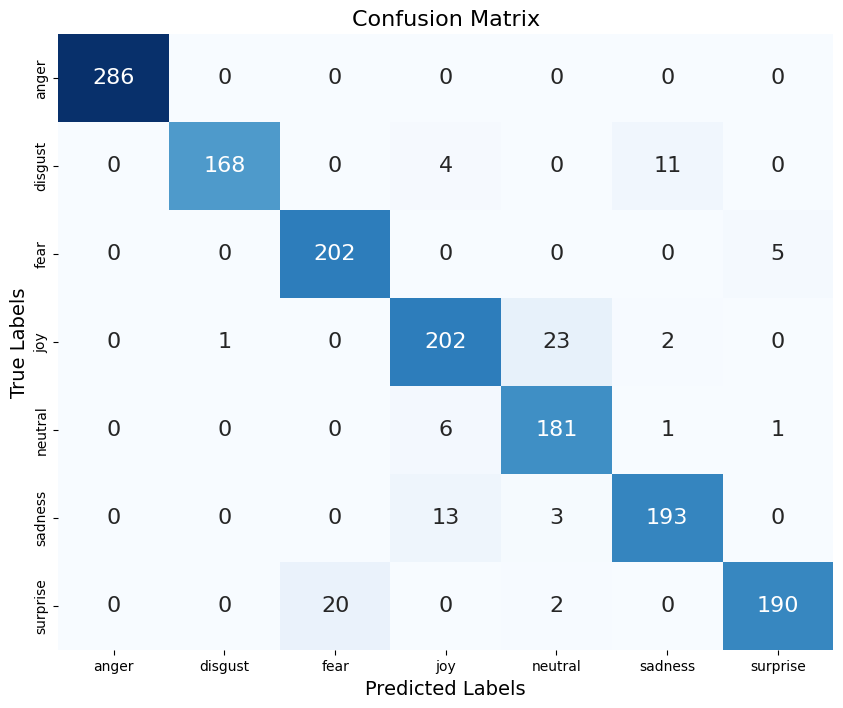

In [24]:
# 2. Create the confusion matrix
confusion_matrix = tf.math.confusion_matrix(labels=test_generator.labels, predictions=predictions)

# Get class names from the generator's class_indices
class_names = list(map(lambda x: x[5:], (test_generator.class_indices.keys())))

# Set up the figure for the heatmap
plt.figure(figsize=(10, 8))

# Use Seaborn's heatmap to plot the confusion matrix
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names, 
            cbar=False, annot_kws={"size": 16})

# Adding labels and title
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)

# Show the plot
plt.show()